In [1]:
%matplotlib inline

In [2]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Model
from keras.metrics import MeanIoU
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

c:\Users\johnn\miniconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
# Set the paths for images and masks
image_path = r'C:\Users\johnn\Downloads\My Notebooks\semantic_segmentation\images'
mask_path = r'C:\Users\johnn\Downloads\My Notebooks\semantic_segmentation\masks'

SIZE = 256
image_dataset = []  
mask_dataset = []  

# Capture training image info as a list
train_images = []

# Load images
images = os.listdir(image_path)
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(os.path.join(image_path, image_name), 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

# Load masks
masks = os.listdir(mask_path)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(os.path.join(mask_path, image_name), 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

# Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1), 3)
# Do not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)), 3) / 255. #Optional since the masks are 255 and 0 (black and white)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

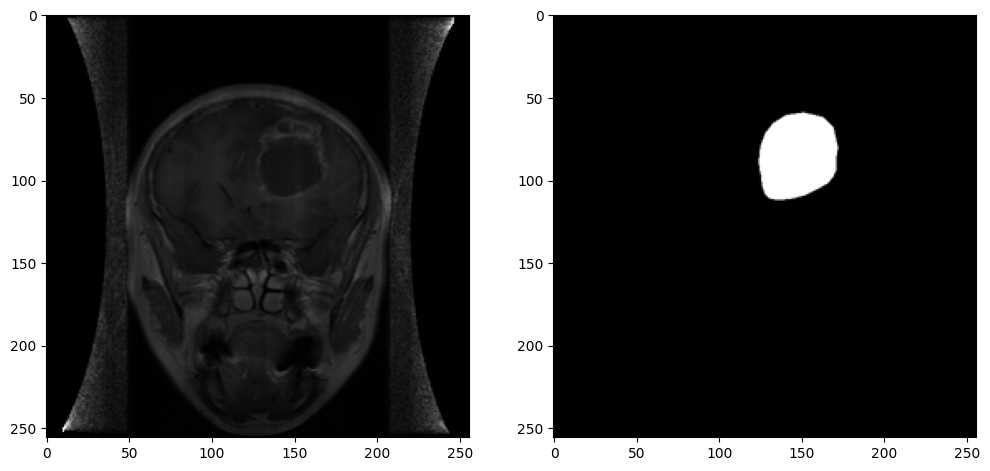

In [5]:
#Check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

###############################################################
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)  # Batch Normalization
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)  # Batch Normalization
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)  # Batch Normalization
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)  # Batch Normalization
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)  # Batch Normalization
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)  # Batch Normalization
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)  # Batch Normalization
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)  # Batch Normalization
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bridge layer
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)  # Batch Normalization
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)  # Batch Normalization

    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)  # Batch Normalization
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)  # Batch Normalization

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)  # Batch Normalization
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)  # Batch Normalization

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)  # Batch Normalization
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)  # Batch Normalization

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)  # Batch Normalization
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)  # Batch Normalization

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [7]:
# Check data types
print(X_train.dtype, y_train.dtype)

# Check pixel values range
print(np.min(X_train), np.max(X_train))

float64 float64
0.0 1.0


In [18]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d_57[0][0]']              
 alization)                     )                                                           

In [19]:
from keras.callbacks import ModelCheckpoint

# Define a checkpoint callback
checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', save_best_only=True)

# Train the model with the callback
history = model.fit(X_train, y_train, 
                    batch_size=16, 
                    verbose=1, 
                    epochs=100,  # Adjust the number of epochs
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    callbacks=[checkpoint])

Epoch 1/100
173/173 [==============================] - 37s 188ms/step - loss: 0.4744 - accuracy: 0.8936 - val_loss: 5.1261 - val_accuracy: 0.4021
Epoch 2/100
173/173 [==============================] - 29s 170ms/step - loss: 0.1471 - accuracy: 0.9845 - val_loss: 0.2684 - val_accuracy: 0.8931
Epoch 3/100
173/173 [==============================] - 30s 172ms/step - loss: 0.0680 - accuracy: 0.9858 - val_loss: 0.0961 - val_accuracy: 0.9736
Epoch 4/100
173/173 [==============================] - 30s 175ms/step - loss: 0.0525 - accuracy: 0.9858 - val_loss: 0.0658 - val_accuracy: 0.9777
Epoch 5/100
173/173 [==============================] - 31s 177ms/step - loss: 0.0380 - accuracy: 0.9876 - val_loss: 0.0428 - val_accuracy: 0.9859
Epoch 6/100
173/173 [==============================] - 31s 178ms/step - loss: 0.0301 - accuracy: 0.9891 - val_loss: 0.0387 - val_accuracy: 0.9870
Epoch 7/100
173/173 [==============================] - 31s 180ms/step - loss: 0.0271 - accuracy: 0.9897 - val_loss: 0.0317 -

In [10]:
from keras.callbacks import ModelCheckpoint

# Load the model architecture (assuming the model architecture is the same)
loaded_model = get_model()

# Load the weights
loaded_model.load_weights('best_model.hdf5')

# Compile the model before continuing training
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a checkpoint callback to save the weights during additional training
checkpoint_continued = ModelCheckpoint('best_model_continued.hdf5', monitor='val_loss', save_best_only=True)

# Continue training the model with the callback
additional_epochs = 50  # Adjust the number of additional epochs
history_continued = loaded_model.fit(X_train, y_train, 
                                     batch_size = 16, 
                                     verbose = 1, 
                                     epochs = additional_epochs,  # Specify the number of additional epochs
                                     validation_data = (X_test, y_test), 
                                     shuffle = False,
                                     callbacks = [checkpoint_continued])

# Evaluate the model
_, acc = loaded_model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [20]:
#Evaluate the model


	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

10/10 [==============================] - 6s 335ms/step - loss: 0.0310 - accuracy: 0.9934
Accuracy =  99.34250116348267 %


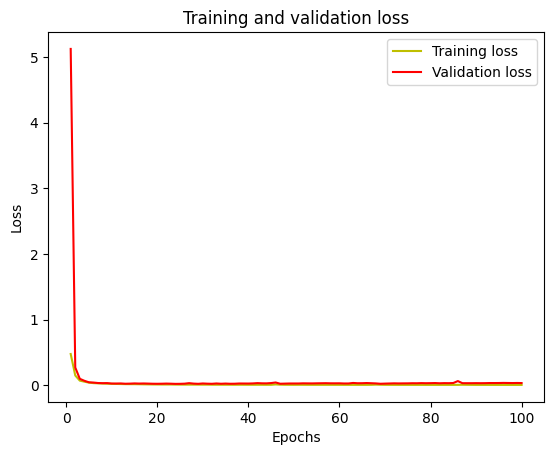

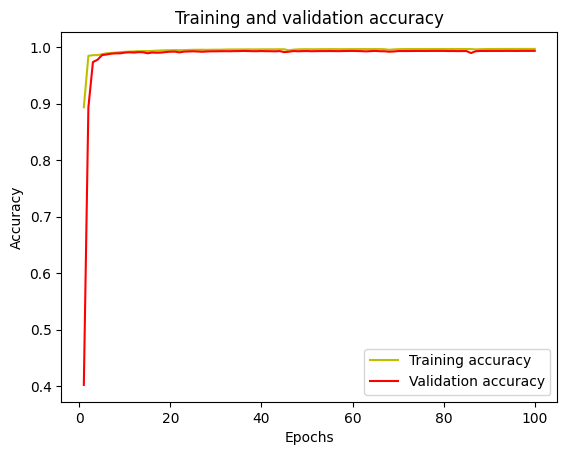

In [21]:
#plot the training and validation accuracy and loss at each epoch
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

10/10 [==============================] - 1s 82ms/step
IoU socre is:  0.7076508357942077


In [23]:
# Predict on a few images
model = get_model()
model.load_weights('best_model.hdf5')  # Trained for 50 epochs

# Assuming you used 10% for the test set
test_size = 0.10
num_test_images = int(len(X_test) * test_size)

# Randomly select an image from the test set
test_img_number = random.randint(0, num_test_images)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

# Normalize the image for prediction
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)

# Perform prediction
prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 32  320         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 32  128        ['conv2d_76[0][0]']              
 ormalization)                  )                                                           

1/1 [==============================] - 0s 25ms/step


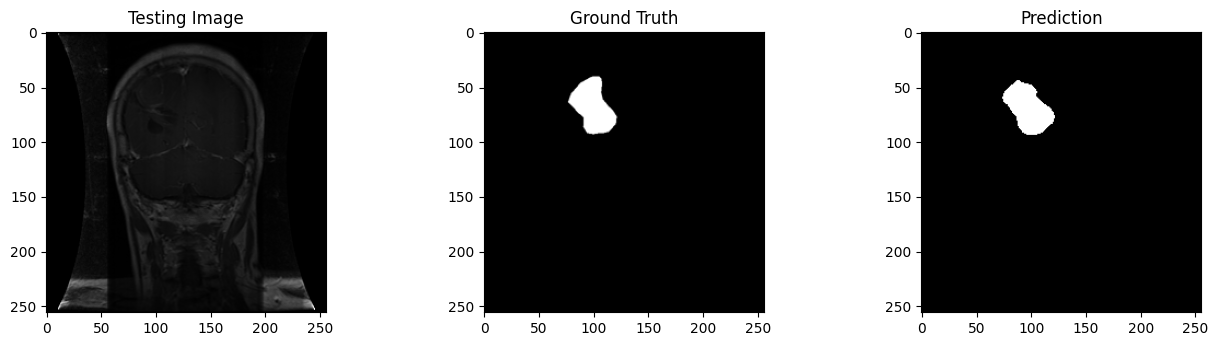

In [24]:
# Predict and threshold for values above 0.5 probability
# Change the probability threshold to a low value (e.g., 0.05) for watershed demo.
prediction_other = (model.predict(test_img_input)[0, :, :, 0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth[:, :, 0], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction, cmap='gray')
# plt.subplot(234)
# plt.title('External Image')
# plt.imshow(test_img_input[0, :, :, 0], cmap='gray')  # Select the first channel
# plt.subplot(235)
# plt.title('Prediction of external Image')
# plt.imshow(prediction_other, cmap='gray')
plt.show()
